This notebook is for visualising and analysing the results of a funnel metadynamics simulation. 

The data files for the plots you see below were are **NOT** included with this script. After installing OpenMM, you will have to run the simulation yourself with ```python run.py```.

Once you have completed the simulations, you can re-run the analysis cell-by-cell with ```Ctrl+Enter``` or ```Shift+Enter```.

In [1]:
import os
import math
import numpy as np

import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import subprocess as sp

In [9]:
if not os.path.isdir('fes_dir'):
    os.mkdir('fes_dir')

if os.path.isfile('HILLS') and not os.path.isfile('fes_dir/fes.dat'):
    sp.call('plumed sum_hills --hills HILLS --stride 500 --idw pp.proj --kt 2.49 --outfile fes_dir/fes_1d.dat --mintozero', shell=True)
    sp.call('plumed sum_hills --hills HILLS --kt 2.49 --outfile fes_dir/fes.dat --mintozero', shell=True)

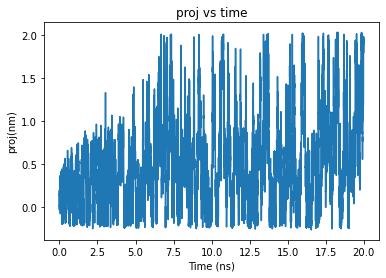

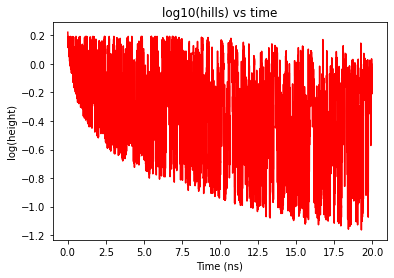

In [10]:
# CVs vs time

df = pd.read_csv(f'HILLS', delim_whitespace=True).iloc[1:,:-2]

df.columns = ['time', 'pp.proj', 'pp.ext', 'sigma_pp.proj', 'sigma_pp.ext', 'height', 'biasf']

# Drop via logic: similar to SQL 'WHERE' clause
df = df[df.time != '#!']
df = df.apply(pd.to_numeric)

plt.title(f'proj vs time')
plt.plot(df.time/1000, df['pp.proj'])
plt.xlabel('Time (ns)')
plt.ylabel('proj(nm)')
plt.show()

plt.title(f'log10(hills) vs time')
plt.plot(df.time/1000, np.log10(df['height']),'r')
plt.xlabel('Time (ns)')
plt.ylabel('log(height)')
plt.show()

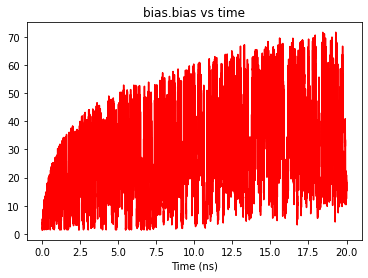

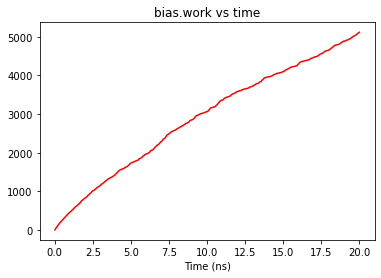

In [11]:
# CVs vs time

df = pd.read_csv(f'COLVAR', delim_whitespace=True).iloc[1:,:-2]

df.columns = ['time', 'pp.proj', 'pp.ext', 's_cent', 'beta_cent', 'wall_width', 'wall_buffer',
              'lwall.bias', 'lwall.force2', 'uwall.bias', 'uwall.force2', 'wall_center',
              'scaling', 'spring', 'wall_bias', 'finalbias.bias',
              'finalbias.wall_bias_bias','meta.bias','meta.work']

# Drop via logic: similar to SQL 'WHERE' clause
df = df[df.time != '#!']
df = df.apply(pd.to_numeric)

# bias at the current CV value, at this time
plt.title(f'bias.bias vs time')
plt.plot(df.time/1000, df['meta.bias'], 'r')
plt.xlabel('Time (ns)')
plt.show()

# total amount of bias 
plt.title(f'bias.work vs time')
plt.plot(df.time/1000, df['meta.work'], 'r')
plt.xlabel('Time (ns)')
plt.show()

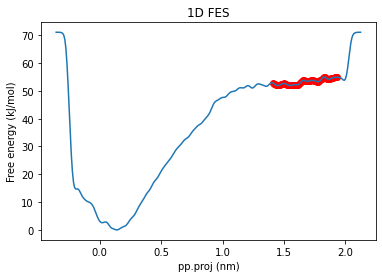

Free energy difference of 53.27 kJ/mol


In [26]:
fes_1d = np.loadtxt(f'fes_dir/fes_1d.dat20.dat')
plt.title('1D FES')
plt.plot(fes_1d[:,0], fes_1d[:,1])
plt.scatter(fes_1d[200:260,0], fes_1d[200:260,1],c='r')
plt.xlabel('pp.proj (nm)')
plt.ylabel('Free energy (kJ/mol)')
plt.show()

print(f'Free energy difference of {np.mean(fes_1d[200:260,1]):.2f} kJ/mol')

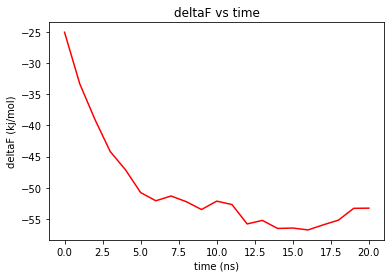

In [27]:
estimates = {}
for i in range(0,21):
    fes_1d = np.loadtxt(f'fes_dir/fes_1d.dat{i}.dat')
    estimates[i] = -np.mean(fes_1d[200:260,1])

plt.title('deltaF vs time')
plt.plot(estimates.keys(), estimates.values(),'r')
plt.xlabel('time (ns)')
plt.ylabel('deltaF (kj/mol)')
plt.show()


NOTE - deltaF requires a correction term to become deltaG

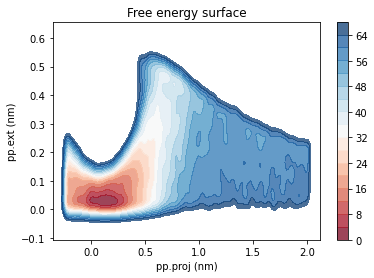

In [25]:
fes=np.loadtxt('fes_dir/fes.dat')

x=fes[:,0]
y=fes[:,1]
z=fes[:,2]

N=200
xi = np.linspace(x.min(), x.max(), N*2)
yi = np.linspace(y.min(),y.max(), N)
zi = scipy.interpolate.griddata((x, y), (z-z.min()), (xi[None,:], yi[:,None]), method='cubic')

cmap='RdBu'

plt.title('Free energy surface')

plt.ylabel('pp.ext (nm)')
plt.xlabel('pp.proj (nm)')

plt.contourf(xi, yi, zi, np.arange(0, 70, 4), cmap=cmap, alpha=.75)
plt.colorbar()
plt.show()